# Competition 3: Customer Satisfaction From Reviews 
## Paula Ottens, Zening Zheng, Max Toorians

In [1]:
# Importing packages

library(tidyverse)
library(tidytext)


# Data attached to this notebook

list.files(path = "../input")

# Using this to hopefully have more computational power
doMC::registerDoMC(cores = 4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "bda2021amazon"

# 1. The project

Answer the 3 most important questions for any ML project:

1. Where do the data come from? (To which population will results generalize?) 
<space><space> <em>The Data come from [this website](http://jmcauley.ucsd.edu/data/amazon/), which is a repository with Amazon customer review data on different categories such as Baby, Beauty or Musical instruments. The data used in this notebook will be used to predict baby product satisfaction, and thus will generalize towards reviews oriented at this subject specifically. </em>

2. What are candidate machine learning methods? (models? features?)   
<space><space> <em>Potential machine learning methods are logistic regression, ridge and lesso regression or methods such as backward predcitor selection<em> 


3. What is the Bayes' error bound? 
<space><space> <em>Considering that our outcome variable is binomial, and the test data is distributed in an unsatisfied ( 1 star (12735), 2 stars (9448)) versus satisfied (3 stars (14010), 4 stars (27695), 5 stars (89643)) which translate to a chance of 0.8555 having a satisfied review (based on chance) it's not strange to have an extremely low Bayes' error bound. This given the fact that we assume that the test data ratings are distributed in a similar fashion as the training data.<em>


# 2. Read Data

Locate and load the data into memory.

In [2]:
dir("../input", recursive=TRUE)

[1] "bda2021amazon/amazon_baby_testset_sample.csv"
[2] "bda2021amazon/amazon_baby.csv"

In [3]:
# Find the right file path

csv_filepath = dir("..", pattern="amazon_baby.csv", recursive=TRUE, full.names = TRUE)

# Read in the csv file

amazon = read_csv(csv_filepath) %>%
    rownames_to_column('id') 


── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_character(),
  review = col_character(),
  rating = col_double()
)




# 3. Preprocessing

Products differ on quality which will cause the ratings to differ, so we include product identiy as a predictive feature.

In [4]:
# Paste name and review into a single string separated by a "–".
# The new string replaces the original review.

amazon = amazon %>% 
    unite(review, name, review, sep = " — ", remove = FALSE) %>%
    sample_n(5000) # start with smallish sample; for you final model use all data!


## Tokenization
* Use tidytext to break up the text into separate tokens and count the number of occurences per review.
* To keep track of the review to which the review belongs, we added the rownames as id above, which is simply the row number.

In [5]:
reviews = amazon %>% 

   # tokenize reviews at word level
   unnest_tokens(token, review) %>%

    # count tokens within reviews as 'n'
    # (keep id, name, and rating in the result)
    count(id, name, rating, token)

head(reviews)

id,name,rating,token,n
<chr>,<chr>,<dbl>,<chr>,<int>
100014,"Summer Infant Elite DuoMat for Car Seat, Black",5,a,1
100014,"Summer Infant Elite DuoMat for Car Seat, Black",5,and,3
100014,"Summer Infant Elite DuoMat for Car Seat, Black",5,be,1
100014,"Summer Infant Elite DuoMat for Car Seat, Black",5,because,1
100014,"Summer Infant Elite DuoMat for Car Seat, Black",5,being,1
100014,"Summer Infant Elite DuoMat for Car Seat, Black",5,black,1


## Stopwords 

Stopwords are commonly removed in text mining and other language processing algorithms. However, we decided not to remove the stopwords because our model actually performed better with the stopwords. 

# 4. Features engineering
### Our featurs 

1. <span style="color: red;">TFIDF </span>- the product of term frequency and inverse document frequency (we did this for single words and bigrams)
3. <span style="color: red;">NRC </span>- labels each word based on sentiments 

The motivation for $TF_{d,t}$ is simply that the more often a token $t$ occurs in a document, the more likely it is that the topic of the document is closely related to that token. A problem of $TF_{d,t}$ is that it does not take into account that certain words simply occur more frequently because of their role in language (such as 'a', 'but', etc.). 

The motivation for the $IDF_t$ is that the more wide spread the use of a token $t$ is among all documents, the less likely it conveys information about the topic of any particular document. Hence, the more surprising a word is, the more likely it conveys information about the topic of the document in which it is found. 

The $TFIDF_{d,t}$ banks on both of these ideas and quantifies the important of a term for a given document. 

While $TFIDF_{d,t}$ is extensively applied and very successful in document retrieval systems (i.e., search engines), the $IDF_t$ part has much less use over $TF_{d,t}$ in *predictive* models because the $IDF_t$ part simply scales the $TF_{d,t}$ features accross documents. This scaling may have an effect on scale sensitive algorithms like PCA and algorithms that rely on Euclidean distances such as kNN. 

## 4.1 TFIDF for single words

Each word a reviewer uses may entail clues about their overall satisfaction rating of the product in question. Therefore, we decided to compute the TFIDF for every single word or token. We will remove tokens that occur in less than 0.01% of the documents 

In [6]:
single_words <- amazon %>%

    unnest_tokens(words, review, token = 'words', drop = FALSE) %>%

    group_by(id, words) %>%

    mutate(n = n()) %>%

    distinct() %>%

    bind_tf_idf(words, id, n) %>%

    replace_na(list(tf=0, idf=Inf, tf_idf=0)) %>%

    filter(idf <= -log(0.1/100)) %>% # filter out surprise lower than -log(0.1/100) 

    select(id,feature = words, value = tf_idf)  #transform into universal design


head(single_words)

id,feature,value
<chr>,<chr>,<dbl>
146614,tadpoles,0.07845254
146614,transport,0.07213874
146614,playmat,0.07364878
146614,set,0.03004368
146614,we,0.07869120
146614,bought,0.02395139


## 4.2 TFIDF for Bigrams
A bigram is two neighboring tokens such as letters or words. Using certain sets of words in a sentence may tell us something about customer satisfaction. For example, the bigram 'not good' may tell us more about the satisfaction rating of the review than each word on its own. Therefore, we have decided to compute the TFIDF for bigrams as well. We will again remove tokens that occur in less than 0.01% of the documents.

In [7]:
bigram <- amazon  %>%

  unnest_tokens(bigram, review, token = "ngrams", n = 2) %>% 

  group_by(id, bigram) %>%
  
  mutate(n = n()) %>%

  distinct() %>%

  bind_tf_idf(bigram, id, n) %>% 

  replace_na(list(tf=0, idf=Inf, tf_idf=0)) %>%

  filter(idf <= -log(0.1/100)) %>% # filter out surprise lower than -log(0.1/100) 

  select(id,feature = bigram, value = tf_idf)  #transform into universal design


head(bigram)

id,feature,value
<chr>,<chr>,<dbl>
146614,playmat set,0.08534134
146614,set we,0.08534134
146614,we bought,0.04822301
146614,bought this,0.03483614
146614,this for,0.03954445
146614,for our,0.04027393


## 4.3 NRC

We decided to use the NRC because we thought that the sentiment scores may differ between a satisfactory and an unsatisfactory review. Even if this introduces multicollinearity our lasso and ridge regression models will, later on, take care of this automatically.

In [8]:
# loading the NRC lexicon

load_nrc = function() {
    
  if (!file.exists('nrc.txt'))
      
        download.file("https://www.dropbox.com/s/yo5o476zk8j5ujg/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt?dl=1",'nrc.txt')
    
  nrc = read.table('nrc.txt', col.names=c('words','sentiment','applies'), stringsAsFactors = FALSE)
    
  nrc %>% 
    
    filter(applies==1) %>% 
    
    select(-applies)
}


# load nrc word list
nrc <- load_nrc()


# label each token
nrc_words <- amazon %>%

    unnest_tokens(words, review, token = 'words', drop = FALSE) %>%

    select(id,words)



nrc_labelled <- inner_join(nrc_words, nrc, by = 'words') %>%

    count(id, sentiment) %>%

    spread(sentiment, n, fill = 0) %>% #transform to wide format: single row per review

    data.frame()


#add prefix
colnames(nrc_labelled)[2:ncol(nrc_labelled)] <- paste("nrc_", colnames(nrc_labelled)[2:ncol(nrc_labelled)], sep = "")


#peak at results
head(nrc_labelled)


#transform into universal design
nrc = nrc_labelled %>%
    
    select(id,everything()) %>% 

    gather(2:ncol(nrc_labelled), key = "feature", value = "value")


head(nrc)

,id,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100014,1,3,1,1,3,1,4,1,1,1
2,100039,0,4,1,2,4,1,5,0,3,6
3,100052,0,2,0,1,2,0,2,0,1,1
4,100091,0,2,1,1,2,3,5,3,0,1
5,10012,0,2,0,0,1,0,2,0,2,1
6,100125,0,1,2,0,1,1,1,1,0,1


,id,feature,value
,<chr>,<chr>,<dbl>
1,100014,nrc_anger,1
2,100039,nrc_anger,0
3,100052,nrc_anger,0
4,100091,nrc_anger,0
5,10012,nrc_anger,0
6,100125,nrc_anger,0


## Bringing all features together
The final data set is a universal feature set in which all features that we use populate one column on their respective values in another column. Specifically, the feature column includes all the words, all the nrc labels, and the bigrams while the value column contains all the values such as the tf_idfs and the nrc scores. This universal data set is needed to create the document term matrix later on. 

In [9]:
# join all features by id 
final = single_words %>%
        
        bind_rows(nrc,bigram)


#peak at the results
head(final)


rm(single_words, nrc, bigram, reviews)

id,feature,value
<chr>,<chr>,<dbl>
146614,tadpoles,0.07845254
146614,transport,0.07213874
146614,playmat,0.07364878
146614,set,0.03004368
146614,we,0.07869120
146614,bought,0.02395139


## Correlated features

Although correlated features may exist, with thousands of features it's computationally too cumbersome to try to remove them directly. Instead we'll have to rely on the properties of the Lasso and Ridge regression to deal with them.




# 5. Models

The models that we will use are lasso Lasso and Ridge regression. These involve methods that are able to take many features while automatically reducing redundant flexibility to any desired level. Multicollinearity, the epithome of reduancy, is also automatically taken care of by these methods.


## 5.1 Sparse design matrix 

Before we fit the model, we turned the features into a sparse design matrix. We splitted the sparse design matrix into our training and test data to later on fit the model and make predictions.

In [10]:
#documents are the id's or different reviews, the terms are the features (e.g., words) 
X = final %>% 
    
    cast_sparse(id,feature,value) %>%

   .[!is.na(rownames(.)),]

#splitting document term matrix into test (i.e., no rating available) and training data 
X_train = X[!is.na(amazon$rating),]
X_test =  X[is.na(amazon$rating),]

X_train[1:8,20:25]
cat("rows, columns: ", dim(X))

X_test[1:8,20:25]
cat("rows, columns: ", dim(X))


8 x 6 sparse Matrix of class "dgCMatrix"
               up      every      night          so       that         the
146614 0.01874206 0.03496453 0.03645987 0.025618693 0.01093393 0.009757642
50422  .          0.02901312 .          .           0.01814567 0.009716120
175425 .          .          .          0.009166321 .          0.006982533
129314 .          .          .          .           .          .          
113778 0.02838603 .          .          0.009700282 0.01656013 0.004433569
177553 .          .          .          .           .          0.010147948
147274 .          .          .          .           .          0.004910297
20031  .          .          .          0.022202867 0.03790429 0.003382649

rows, columns:  5000 18157

8 x 6 sparse Matrix of class "dgCMatrix"
                up every      night          so        that         the
114127 .               . .          .           .           .          
104275 .               . .          .           0.010400568 0.011137991
116139 0.018047906     . .          .           0.010528970 0.015033996
79982  .               . .          .           0.007753151 0.011070488
146659 0.073094017     . .          .           .           0.003805480
171999 0.022375720     . .          0.015292791 0.008702516 0.010096172
129995 .               . 0.01834755 0.006445994 0.016506708 0.005892357
18943  0.008616191     . .          0.005888776 0.011728735 0.009868829

rows, columns:  5000 18157

In [11]:
#check dimensions of test and train set 
dim(X_train)
dim(X_test)

[1]  4220 18157

[1]   780 18157

## 5.2 Transforming rating into a dummy variable

We also needed to transform the ratings into a dummy variable, where ratings higher than three were satisfactory and ratings lower than four were unsatisfactory. So this is what we did here:

In [12]:
train_new <- amazon %>%
    
    filter(!is.na(rating)) %>%

    mutate(rating = ifelse(rating > 3,1,0))

#peak at results
dim(train_new)
head(train_new)

# 1 = satisfactory
# 0 = unsatisfactory 

[1] 4220    4

id,review,name,rating
<chr>,<chr>,<chr>,<dbl>
146614,"Tadpoles Transport Playmat Set — We bought this for our son to play on because we have wood floors. We picked it up every night so that the dogs didn\'t trample all over it, and the shapes in each square would always fall out, so the next day we\'d have to put it back together. Then a few of the shapes started shrinking, and would no longer fit in it\'s cut-out. We returned the product.",Tadpoles Transport Playmat Set,0
50422,"Sleeping Partners 3 Bulb Mini Chandelier - Pink Sapphire — This is a great product for a little girls room or nursery. This is the second one that we have purchased, we purchased the first one three years ago when our first daughter was born and now we bought the pink one for her little sisters nursery. They are easy to install on your own and they are the perfect size for smaller rooms and give off a good light. We really love them and they give the room the look that every little girl wants!",Sleeping Partners 3 Bulb Mini Chandelier - Pink Sapphire,1
175425,"Stroller Organizer - Deluxe, Luxury And Designer Black Baby Stroller Organizer - Comes With Extra Cup Holders Ideal for Drinks, Sippy Cups, Water Bottles, And Baby Bottles - Guaranteed To Keep Your Baby Stroller Accessories Safe And Secure With The Three Extra Pockets - Stays Firmly Fixed In One Place Like A Console - Universal And Designed To Fit Most Strollers - Protect Your Investment - Comes With A Lifetime Guarantee! — Our straw cups (Playtex) do not fit in the carrier like in the picture but we are still happy with it. It does organize everything on the stroller and we like the mesh pocket so we can listen to music on our phone while walking.","Stroller Organizer - Deluxe, Luxury And Designer Black Baby Stroller Organizer - Comes With Extra Cup Holders Ideal for Drinks, Sippy Cups, Water Bottles, And Baby Bottles - Guaranteed To Keep Your Baby Stroller Accessories Safe And Secure With The Three Extra Pockets - Stays Firmly Fixed In One Place Like A Console - Universal And Designed To Fit Most Strollers - Protect Your Investment - Comes With A Lifetime Guarantee!",1
129314,"Double Blessings Double Take Twin Sling-Color: Cheetah/Black [Baby Product] — If I could rate this zero stars, I would. PLEASE don\'t put your child in this. There is no safe way to use this product.",Double Blessings Double Take Twin Sling-Color: Cheetah/Black [Baby Product],0
113778,"Britax Child Cup Holder — Britax is my number one choice for my children\'s safety. I was not surpriised that this cupholder held up to it\'s name. I thought at first that it looked a little too far forward on the seat (was worried daughter wouldn\'t be able to reach her sippy), but it is actually placed perfectly. My tot can reach with no problem and the cup hold up great! It sets in the seat solidly, has an ever so slight tilt depending on height of item inside, but tilt not necessary, just bonus. I\'m happy happy!! Highly recommended",Britax Child Cup Holder,1
177553,"Everything for Kids 3 Piece Toddler Sheet Set, Navy — The sheets feel light and a little silky. Very utilitarian, no trimming details. No complaints from the toddler who uses them.","Everything for Kids 3 Piece Toddler Sheet Set, Navy",1


## 5.3 Pull ratings from the training data set 

Finally, we pulled the target values (i.e., the ratings) from our training design matrix.

In [13]:
y =
    # Make sure rownames in X line up with `id` in `reviews`
    data.frame(id = rownames(X)) %>% 
    
    inner_join(train_new, by = 'id') %>% 

    # Extract 'rating' as a factor
    pull(rating) %>%

    as.factor()


# Verify the result
table(y)

rm(X)

y
   0    1 
1031 3189 

Now, we can use lasso and ridge regression. We chose the familiy 'binomial' because we are dealing with a dichotomous response variable.

## 5.4 Lasso

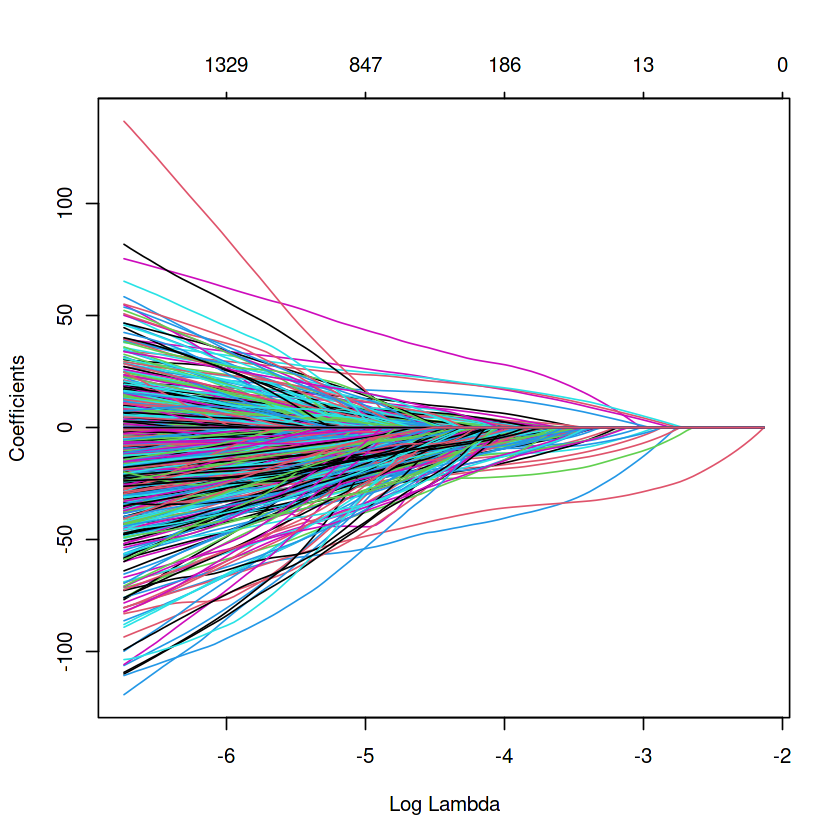

In [14]:
lasso = glmnet::glmnet(X_train, y, family="binomial", alpha = 1)

#check results in plot
plot(lasso, 'lambda')

In [15]:
#use cv.glmnet() because of its built-in cross-validation function
cv_fitlasso <- glmnet::cv.glmnet(X_train, y, family = "binomial", 
                                 parallel = TRUE, type.measure = "auc", nfolds = 4, alpha = 1)

cv_fitlasso

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1




Call:  glmnet::cv.glmnet(x = X_train, y = y, type.measure = "auc", nfolds = 4,      parallel = TRUE, family = "binomial", alpha = 1) 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.01463    46  0.8847 0.01427     297
1se 0.02122    38  0.8728 0.01482     101

## 5.5 Ridge 

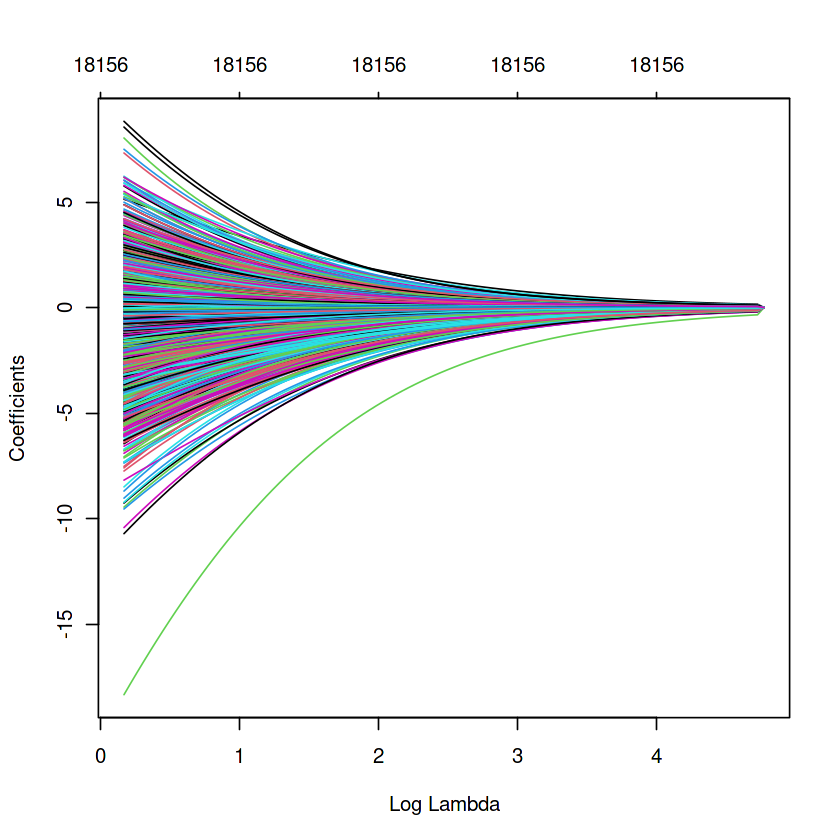

In [16]:
ridge = glmnet::glmnet(X_train, y, family="binomial", alpha = 0)

#check results in plot
plot(ridge, 'lambda')

In [17]:
#use cv.glmnet() because of its built-in cross-validation function
cv_fitridge <- glmnet::cv.glmnet(X_train, y, family = "binomial", 
                                 parallel = TRUE, type.measure = "auc",nfolds = 4, alpha = 0)

cv_fitridge


Call:  glmnet::cv.glmnet(x = X_train, y = y, type.measure = "auc", nfolds = 4,      parallel = TRUE, family = "binomial", alpha = 0) 

Measure: AUC 

    Lambda Index Measure       SE Nonzero
min  108.1     3  0.8668 0.006241   18156
1se  108.1     3  0.8668 0.006241   18156

# 5.6 Model evaluation

First, we plotted our models.

[1] 0.01462565

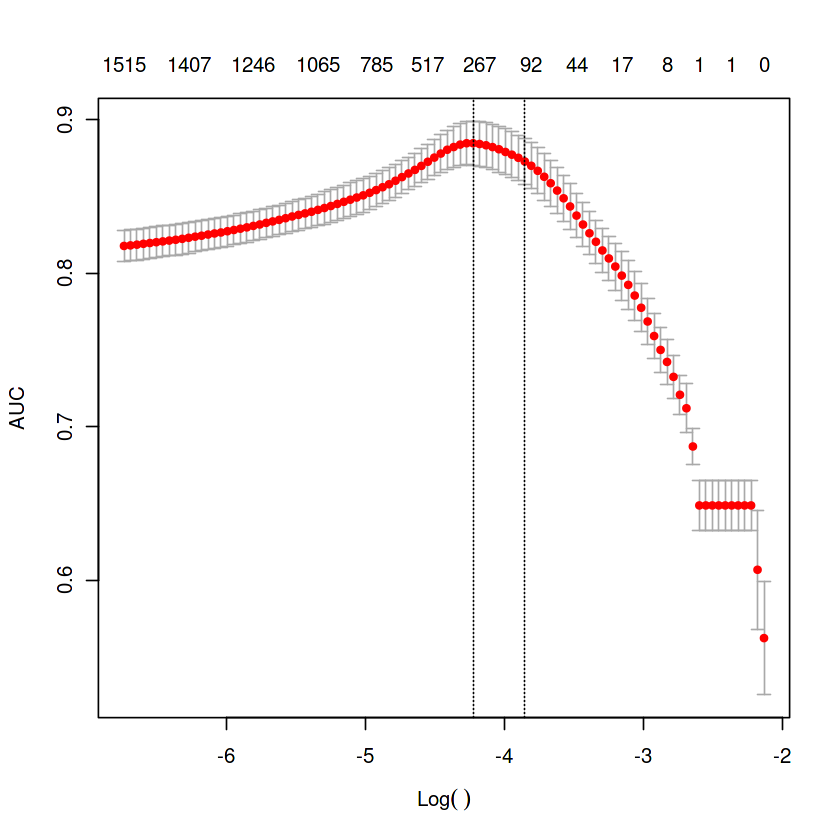

[1] 108.0941

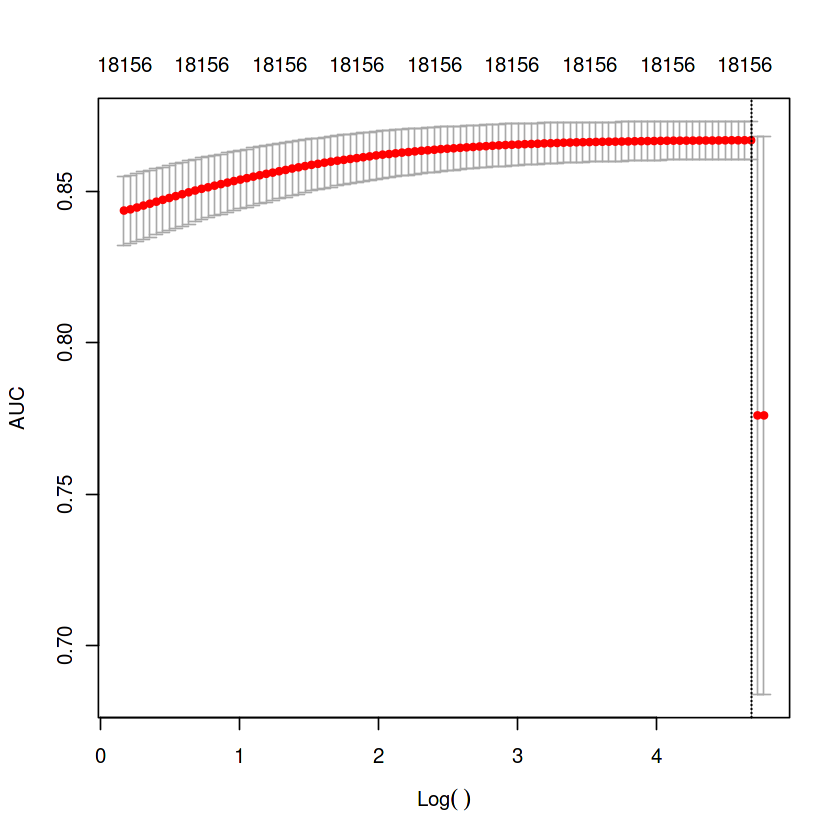

In [18]:
# Plotting Lasso
plot(cv_fitlasso)

cv_fitlasso$lambda.min 


# Plotting ridge
plot(cv_fitridge)

cv_fitridge$lambda.min 


In the plot from the lasso regression, we can see how the accuracy at first increases with lambda and then decreases. The value of lambda will be chosen via cross-validation. In the plot from the ridge regression, we can see cross-validated accuracy scores. As lambda increases, the accuracy increases. The value of lambda will be chosen via cross-validation. 

Next, we compared the performance of the models. 

In [19]:
# we get the cvm from each model fit to get the best performing one
print(max(cv_fitlasso$cvm))

print(max(cv_fitridge$cvm))


[1] 0.8847099
[1] 0.866813


## 5.7 Predicition

Based on our model evaluation, lasso seemed to be the better performing model. Therefore, we decided to use this model for our predictions. 

In [20]:
# Lasso
pred_lasso <- predict(cv_fitlasso, X_test, s = 'lambda.1se', type = 'response') 


# 6. Submitting your predictions

A sample file displays correct submission format:

In [21]:
sample_filepath = dir("..", pattern="sample.csv", recursive=TRUE, full.names = TRUE)

sample_submission = read_csv(sample_filepath, col_types = cols(col_character(), col_double()))

head(sample_submission)

Id,Prediction
<chr>,<dbl>
3,0.5715225
5,0.9033234
8,0.7865691
14,0.6911136
20,0.7673936
22,0.1852140


Lastly, we write our predictions into the correct submission format as shown above:

In [22]:
submission <- data.frame(Id = rownames(pred_lasso), Prediction = pred_lasso[,1])

write_csv(submission, path = "predictions.csv")

head(submission)

Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


,Id,Prediction
,<chr>,<dbl>
114127,114127,0.8768830
104275,104275,0.8310651
116139,116139,0.8115189
79982,79982,0.8149667
146659,146659,0.8349278
171999,171999,0.6682182


# Labor division

- Paula: feature, extraction, creating feature data frame, formatting, descriptions 
- Zena: model fit, make prediction, tidy the format, NRC debug,
- Max: feature extraction, predictions, the three questions